# CODEATHON 2: Recognizing UVA landmarks with neural nets (50 pts)
![UVA Grounds](https://giving.virginia.edu/sites/default/files/2019-02/jgi-teaser-image.jpg)

The UVA Grounds is known for its Jeffersonian architecture and place in U.S. history as a model for college and university campuses throughout the country. Throughout its history, the University of Virginia has won praises for its unique Jeffersonian architecture.

In this codeathon, you will attempt the build an image recognition system to classify different buildlings/landmarks on Grounds. You will earn 50 points for this codeathon plus 10 bonus points. To make it easier for you, some codes have been provided to help you process the data, you may modify it to fit your needs. You must submit the .ipynb file via UVA Collab with the following format: yourcomputingID_codeathon_2.ipynb

In [2]:
import sys
import sklearn
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

np.random.seed(42)
tf.random.set_seed(42)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


# Step 2: Process the  Dataset
The full dataset is huge (+37GB) with +13K images of 18 classes. So it will take a while to download, extract, and process. To save you time and effort, a subset of the data has been resized and compressed to only 379Mb and stored in my Firebase server. This dataset will be the one you will benchmark for your grade. If you are up for a challenge (and perhaps bonus points), contact the instructor for the full dataset!

In [3]:
# Download dataset from Firebase
!wget https://firebasestorage.googleapis.com/v0/b/uva-landmark-images.appspot.com/o/dataset.zip?alt=media&token=e1403951-30d6-42b8-ba4e-394af1a2ddb7

--2023-11-10 17:27:38--  https://firebasestorage.googleapis.com/v0/b/uva-landmark-images.appspot.com/o/dataset.zip?alt=media
Resolving firebasestorage.googleapis.com (firebasestorage.googleapis.com)... 142.251.172.95, 74.125.132.95, 74.125.201.95, ...
Connecting to firebasestorage.googleapis.com (firebasestorage.googleapis.com)|142.251.172.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 397174132 (379M) [application/zip]
Saving to: ‘dataset.zip?alt=media’

dataset.zip?alt=med 100%[===================>] 378.77M  20.2MB/s    in 5.6s    

2023-11-10 17:27:44 (68.2 MB/s) - ‘dataset.zip?alt=media’ saved [397174132/397174132]



In [4]:
# Extract content
!unzip "/content/dataset.zip?alt=media"

Streaming output truncated to the last 5000 lines.
  inflating: dataset/Rotunda/0000010694.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010694.jpg  
  inflating: dataset/Rotunda/0000010680.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010680.jpg  
  inflating: dataset/Rotunda/0000010858.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010858.jpg  
  inflating: dataset/Rotunda/0000010870.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010870.jpg  
  inflating: dataset/Rotunda/0000010864.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010864.jpg  
  inflating: dataset/Rotunda/0000010865.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010865.jpg  
  inflating: dataset/Rotunda/0000010871.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010871.jpg  
  inflating: dataset/Rotunda/0000010859.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010859.jpg  
  inflating: dataset/Rotunda/0000010681.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010681.jpg  
  inflating: dataset/R

In [5]:
from sklearn.datasets import load_files


from keras.preprocessing import image
from tqdm import tqdm # progress bar

data_dir = "/content/dataset/"
batch_size = 32;
# IMPORTANT: Depends on what pre-trained model you choose, you will need to change these dimensions accordingly
img_height = 150;
img_width = 150;

# Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 42,
    image_size= (img_height, img_width),
    batch_size = batch_size
)

# Validation Dataset
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 42,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 14286 files belonging to 18 classes.
Using 11429 files for training.
Found 14286 files belonging to 18 classes.
Using 2857 files for validation.


In [ ]:
type(train_ds)

tensorflow.python.data.ops.batch_op._BatchDataset

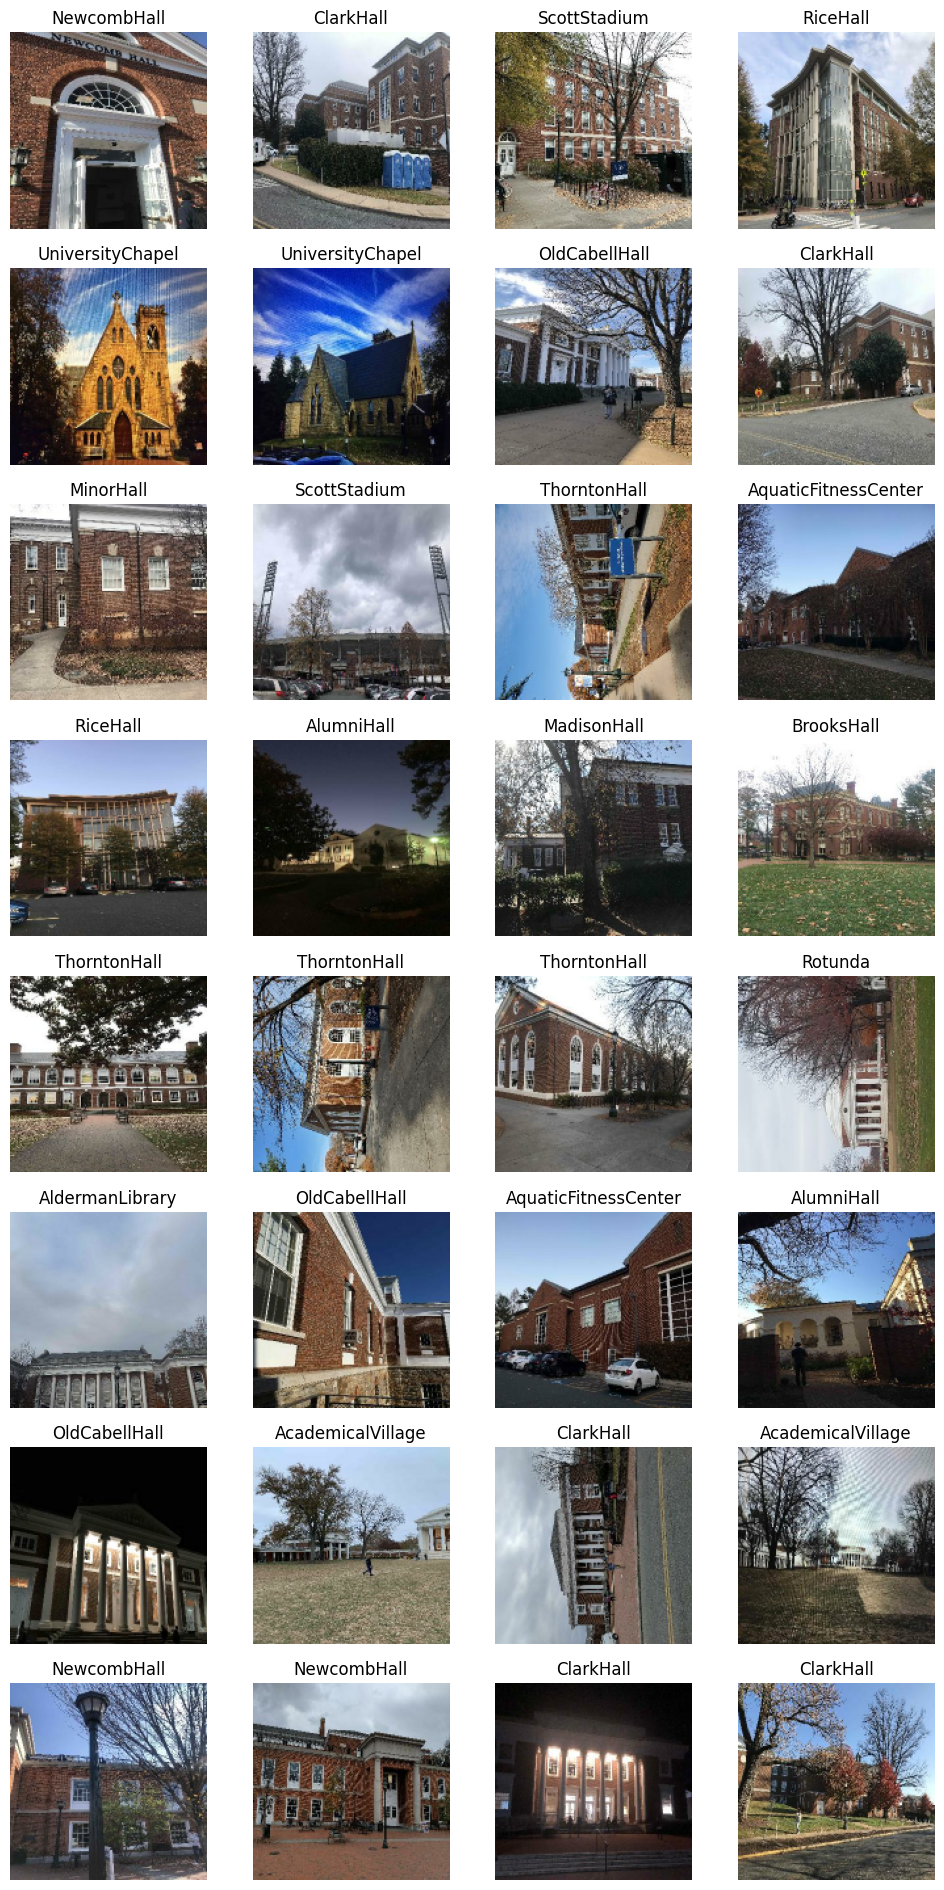

In [16]:
# Visualize some of the train samples of one batch
# Make sure you create the class names that match the order of their appearances in the "files" variable
class_names = ['AcademicalVillage', 'AldermanLibrary', 'AlumniHall', 'AquaticFitnessCenter',
  'BavaroHall', 'BrooksHall', 'ClarkHall', 'MadisonHall', 'MinorHall', 'NewCabellHall',
  'NewcombHall', 'OldCabellHall', 'OlssonHall', 'RiceHall', 'Rotunda', 'ScottStadium',
  'ThorntonHall', 'UniversityChapel']

# Rows and columns are set to fit one training batch (32)
n_rows = 8
n_cols = 4
plt.figure(figsize=(n_cols * 3, n_rows * 3))
for images, labels in train_ds.take(1):
    for i in range (n_rows*n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(class_names[labels[i]], fontsize=12)
plt.subplots_adjust(wspace=.2, hspace=.2)


In [ ]:
# YOUR CODE STARTS HERE

In [6]:
# Extract the X_train, y_train, X_valid, and y_valid from the provided above code

# TRAINING DATA
X_train = []
y_train = []
for images, labels in train_ds:
    X_train.append(images)
    y_train.append(labels)

# Concatenating the batches
X_train = tf.concat(X_train, axis=0)
y_train = tf.concat(y_train, axis=0)

# Printing the shape of data and labels
print("Training Data shape:", X_train.shape)
print("Training Labels shape:", y_train.shape)

print("---------------------------------------------------------------")

# VALIDATION DATA
X_validation = []
y_validation = []
for images, labels in validation_ds:
    X_validation.append(images)
    y_validation.append(labels)

# Concatenating the batches
X_validation = tf.concat(X_validation, axis=0)
y_validation = tf.concat(y_validation, axis=0)

# Printing the shape of data and labels
print("Validation Data shape:", X_validation.shape)
print("Validation Labels shape:", y_validation.shape)

Training Data shape: (11429, 150, 150, 3)
Training Labels shape: (11429,)
---------------------------------------------------------------
Validation Data shape: (2857, 150, 150, 3)
Validation Labels shape: (2857,)


# Step 3: Create your own CNN architecture
You must design your own architecture. To get started, you may get inspiration from one in CNN notebook  (i.e. use one similar to LeNet-5 or AlexNet). You will have to report the design of the architecture:

1.   How many layers does it have?
2.   Why do you decide on a certain number nodes per layer?
3.   Which activation functions do you choose?
4.   How many parameters does it has in total?

Hint: use `myModel.summary()` to learn on the layers and parameters




1. 13 layers - 4 conv, 3 pool, 1 flatten, 2 dropout, 2 dense, 1 output
2. Explanation provided below
3. ReLu for all hidden and softmax for output
4. 22,732,690

# Explanation

To start must ensure that the input layer shape matches the shape we get in the training and validation data we get above. Each image is 150x150 and they are RGB colors so will be 150x150x3 as seen. Must also ensure that our output layer is a softmax activation function with 18 units in order to match the number of classes found in step 2.

Across the board I decided to use the ReLu function as this article (https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/) states that it has become the default activation function and AlexNet seems to perform better than LeNet-5 potentially due to the activation function difference.

At first I was having trouble training the model; however it was confusing because my pre-trained model scored a 0.95 on the validation data. I then discovered that training with "shuffle=True" allowed my accuracy score to greatly increase but the training accuracy was way higher than the validation accuracy so my assumption is that my initial model with shuffle=True was over fitting the data because I was at first trying to solve the bad accuracy scores.

Once I discovered shuffle=True I was able to construct a model similar to AlexNet with multiple convolutional layers stacked, pooling size generally decreasing throughout the model, filters generally increasing, and then Dense ReLu activation layers at the end. To fix the overfitting I used less filters and units in the covolution and dense layers. I also added some more dropout layers since this article suggests that: https://towardsdatascience.com/combating-overfitting-with-dropout-regularization-f721e8712fbe#:~:text=Let's%20recap%20%E2%80%94%20dropout%20is%20a,the%20input%20and%20hidden%20layers. When increasing the dropout percentage and number of layers I increased the epochs so the overfitting would subside while still being trained to get a better validation/training error.



In [34]:
# Your code here
DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

myModel  = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=5, input_shape=[150, 150, 3]),
    keras.layers.MaxPooling2D(pool_size=4),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.AvgPool2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.6),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(18, activation='softmax'),
    ])
myModel.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_54 (Conv2D)          (None, 150, 150, 64)      4864      
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 37, 37, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_55 (Conv2D)          (None, 37, 37, 128)       73856     
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 18, 18, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_56 (Conv2D)          (None, 18, 18, 256)       295168    
                                                                 
 conv2d_57 (Conv2D)          (None, 18, 18, 256)     

After designing the model, you will need to train it. In order to train, you will need to pick a number of `epoch` (iteration), which `optimizer` to use (from  `keras.optimizers`), a `loss` function, and some `metrics`.

In [36]:
myEpochs = 10
myOptimizer = "nadam"

myLoss = "sparse_categorical_crossentropy"

myMetrics = ["accuracy"]
myModel.compile(loss=myLoss, optimizer=myOptimizer, metrics=myMetrics)
# when training batches right now all batches have the same images so it was either focusing
# on either Rotunda or Academical Village. shuffle=True is making sure each batch has a more diverse # of classes
history = myModel.fit(X_train, y_train, epochs=myEpochs, shuffle=True, validation_data=(X_validation, y_validation))

Epoch 1/10
358/358 [==============================] - 11s 23ms/step - loss: 2.8521 - accuracy: 0.1697 - val_loss: 2.3761 - val_accuracy: 0.2720
Epoch 2/10
358/358 [==============================] - 9s 26ms/step - loss: 2.3851 - accuracy: 0.2740 - val_loss: 2.2139 - val_accuracy: 0.3273
Epoch 3/10
358/358 [==============================] - 9s 25ms/step - loss: 1.9849 - accuracy: 0.4063 - val_loss: 1.6719 - val_accuracy: 0.5233
Epoch 4/10
358/358 [==============================] - 9s 26ms/step - loss: 1.6192 - accuracy: 0.5152 - val_loss: 1.5304 - val_accuracy: 0.5527
Epoch 5/10
358/358 [==============================] - 9s 24ms/step - loss: 1.3830 - accuracy: 0.5900 - val_loss: 1.2681 - val_accuracy: 0.6290
Epoch 6/10
358/358 [==============================] - 8s 22ms/step - loss: 1.1217 - accuracy: 0.6640 - val_loss: 1.1462 - val_accuracy: 0.6657
Epoch 7/10
358/358 [==============================] - 8s 23ms/step - loss: 0.9405 - accuracy: 0.7183 - val_loss: 1.0909 - val_accuracy: 0.698

Next, you need to create (1) a plot of training and validation `loss` and (2) a plot of training and validation `accuracy`. These plots might give you some insights about your model performance and possibility of overfitting.

Report the performance of your architecture on the validation set in a `confusion matrix`. Make comments on the performance by answering the following questiosns:
- How well do you think your architecture is doing (overall accuracy)?
- Where did it makes mistake most?
- Which classes can be improved?

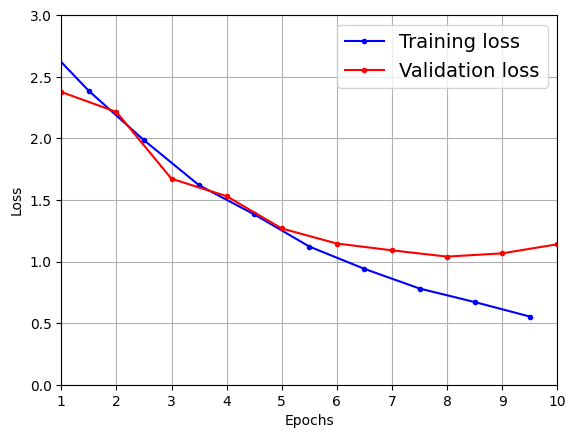

In [38]:
# Your evaluation code here
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 10, 0, 3])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])

In [39]:
def plot_accuracy_curves(accuracy, val_accuracy):
    plt.plot(np.arange(len(accuracy)) + 0.5, accuracy, "b.-", label="Training accuracy")
    plt.plot(np.arange(len(val_accuracy)) + 1, val_accuracy, "r.-", label="Validation accuracy")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 10, 0, 1])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.grid(True)

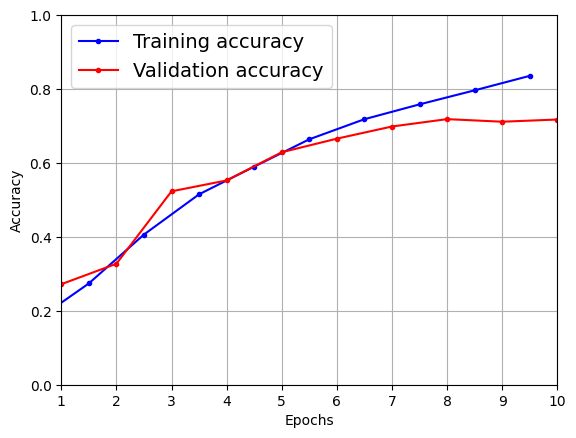

In [40]:
plot_accuracy_curves(history.history["accuracy"], history.history["val_accuracy"])

# Accuracy

Overall for a rather simple custom CNN approach my model performs pretty well. At first it was greatly overfitting the data with a large gap between the training accuracy and the validation accuracy but after more dropping out and less filters we are getting slightly lower accuracies of 0.83 instead of 0.92, but much better validation accuracies of 0.72 instead of 0.62. Solving the overfitting has led to better predictions for generalized data than before.

In [41]:
# confusion matrix
from sklearn.metrics import confusion_matrix

#Predict
y_prediction = myModel.predict(X_validation)

# converting the predictions into labels assuming one-hot
predicted_labels = np.argmax(y_prediction, axis=1)


#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_validation, predicted_labels)

print(class_names)
print(result)

90/90 [==============================] - 1s 7ms/step
['AcademicalVillage', 'AldermanLibrary', 'AlumniHall', 'AquaticFitnessCenter', 'BavaroHall', 'BrooksHall', 'ClarkHall', 'MadisonHall', 'MinorHall', 'NewCabellHall', 'NewcombHall', 'OldCabellHall', 'OlssonHall', 'RiceHall', 'Rotunda', 'ScottStadium', 'ThorntonHall', 'UniversityChapel']
[[ 55   2   2   1   0   1   1   1   2   0   0   4   0   1   7   1   0   1]
 [  2 109   2   1   1   0   0   0   6   1   0   5   5   7   5   3   1   0]
 [  1   1  69   0   0   0   0   0   1   0   1   0   0   1   2   2   3   1]
 [  2   0   1  72   0   5   0   0   1   2   6   0   0   5   0  14   5   5]
 [  0   0   0   1  13   2   0   0   2   1   0   1   0   4   0   0   2   1]
 [  0   0   0   2   1  54   0   0   0   3   0   1   0  11   1   1   0   6]
 [  0   1   6   1   3   2 112   1   4   7   2   7   0   5   6   4   7   3]
 [  1   5   3   6   0   2   0  25   0   0   0   2   1   2   6   4   2   7]
 [  0   5   6   3   0   1   0   7  84   3   1   1   1  13   5

In [52]:
from sklearn.metrics import classification_report

report = classification_report(y_validation, predicted_labels)

print(report)
print(class_names)

              precision    recall  f1-score   support

           0       0.65      0.70      0.67        79
           1       0.74      0.74      0.74       148
           2       0.61      0.84      0.71        82
           3       0.54      0.61      0.57       118
           4       0.45      0.48      0.46        27
           5       0.55      0.68      0.60        80
           6       0.90      0.65      0.76       171
           7       0.53      0.38      0.44        66
           8       0.67      0.58      0.62       144
           9       0.64      0.60      0.62       130
          10       0.76      0.64      0.69       141
          11       0.72      0.69      0.71       167
          12       0.87      0.73      0.80       215
          13       0.69      0.85      0.76       284
          14       0.80      0.81      0.81       306
          15       0.73      0.77      0.75       278
          16       0.73      0.69      0.71       241
          17       0.74    

# Improvements

As seen above the confusion matrix had the most issues with classes 3, 4, and 7. These correspond to AquaticFitnessCenter, BavaroHall, and Madison Hall. BavaroHall and Madison Hall have are the two with the least support, which means they have a lack of training data so it is not surprising they score badly.

The AFC is also a huge brick square that looks different from many different angles so it is also not surprisingly this is hard to classify.

# Step 4: Use a Pre-trained Network with Transfer Learning
Now that you have a your own custom model and some baseline performance, let's see if you can improve the performance using transfer learning and a pre-trained model. You may use any pre-trained model EXCEPT ones that already provided such as `Xception`, `MobileNet`, `EfficientNetB6`. Keep in mind that each pre-trained model may expect a different input shape, so adjust the size of your training images accordingly.

Make sure you report the design of this architecture by answer the same questions 1-4 in Step 3.

Hint: use `ImageNet` as weights when load the pre-train network, then add a `GlobalAveragePooling2D` and an output layer with `softmax` activation.



In [64]:
# Your code here
# decided efficientnetv2m because: https://keras.io/api/applications/.
# it has one of the best top5 accuracies and it is nearly half the size of efficientnetv2l
base = keras.applications.EfficientNetV2M(weights="imagenet", include_top=False)

avg_layer = keras.layers.GlobalAveragePooling2D()(base.output)
output = keras.layers.Dense(18, activation="softmax")(avg_layer)

final_model = keras.Model(inputs=base.input, outputs=output)

Next, you will attempt to adapt this pre-trained model to your UVA Landmark dataset. It is recommended that you tried the two-phase training approach for your model:

1.   Phase 1: Freeze the pre-train weights and only train the top layer
2.   Phase 2: Train the entire network with much smaller learning rate (adapt the model to UVA data, but avoid destroying the transfered weights).



In [65]:
# Phase 1 code here
for layer in base.layers:
  layer.trainable = False

# momentum supposedly accelerates gradient descent
# changing nesterov=True seems to produce way better accuracy scores for even just training the top layers
optimizer = keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=True)
final_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

phase1_history = final_model.fit(X_train, y_train,
                          steps_per_epoch=int(X_train.shape[0]*0.9 / batch_size),
                          validation_data=(X_validation,y_validation),
                          validation_steps=int(X_validation.shape[0]*0.9 / batch_size),
                          epochs=10)

Epoch 1/10
321/321 [==============================] - 41s 63ms/step - loss: 1.3032 - accuracy: 0.6213 - val_loss: 0.9561 - val_accuracy: 0.7462
Epoch 2/10
321/321 [==============================] - 15s 48ms/step - loss: 0.8777 - accuracy: 0.7463 - val_loss: 0.8389 - val_accuracy: 0.7749
Epoch 3/10
321/321 [==============================] - 15s 48ms/step - loss: 0.7638 - accuracy: 0.7808 - val_loss: 0.8018 - val_accuracy: 0.7854
Epoch 4/10
321/321 [==============================] - 15s 47ms/step - loss: 0.6946 - accuracy: 0.8009 - val_loss: 0.7651 - val_accuracy: 0.7910
Epoch 5/10
321/321 [==============================] - 15s 48ms/step - loss: 0.6469 - accuracy: 0.8122 - val_loss: 0.7283 - val_accuracy: 0.8033
Epoch 6/10
321/321 [==============================] - 15s 48ms/step - loss: 0.6085 - accuracy: 0.8252 - val_loss: 0.7081 - val_accuracy: 0.8089
Epoch 7/10
321/321 [==============================] - 15s 47ms/step - loss: 0.5875 - accuracy: 0.8331 - val_loss: 0.7234 - val_accuracy:

321/321 [==============================] - 15s 46ms/step - loss: 0.5252 - accuracy: 0.8501 - val_loss: 0.6854 - val_accuracy: 0.8103


In [66]:
# Phase 2 code here
for layer in base.layers:
  layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

final_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

phase2_history = final_model.fit(X_train, y_train,
                    steps_per_epoch=int(X_train.shape[0]*0.9 / batch_size),
                    validation_data=(X_validation,y_validation),
                    validation_steps=int(X_validation.shape[0]*0.9 / batch_size),
                    epochs=10)

Epoch 1/10
321/321 [==============================] - 130s 160ms/step - loss: 0.6781 - accuracy: 0.8221 - val_loss: 0.3204 - val_accuracy: 0.9254
Epoch 2/10
321/321 [==============================] - 47s 146ms/step - loss: 0.1260 - accuracy: 0.9684 - val_loss: 0.2645 - val_accuracy: 0.9461
Epoch 3/10
321/321 [==============================] - 47s 146ms/step - loss: 0.0354 - accuracy: 0.9898 - val_loss: 0.2959 - val_accuracy: 0.9440
Epoch 4/10
321/321 [==============================] - 47s 146ms/step - loss: 0.0237 - accuracy: 0.9940 - val_loss: 0.3039 - val_accuracy: 0.9450
Epoch 5/10
321/321 [==============================] - 47s 146ms/step - loss: 0.0183 - accuracy: 0.9958 - val_loss: 0.3314 - val_accuracy: 0.9475
Epoch 6/10
321/321 [==============================] - 47s 147ms/step - loss: 0.0146 - accuracy: 0.9963 - val_loss: 0.3331 - val_accuracy: 0.9527
Epoch 7/10
321/321 [==============================] - 47s 146ms/step - loss: 0.0102 - accuracy: 0.9977 - val_loss: 0.3216 - val_a

321/321 [==============================] - 44s 137ms/step - loss: 0.0123 - accuracy: 0.9964 - val_loss: 0.3238 - val_accuracy: 0.9566


# Architecture

1.   How many layers does it have?

      Outputted below in final_model.summary()

2.   Why do you decide on a certain number nodes per layer?

      For this model I used the pretrain model found in Keras called EfficientNetV2M. I used this because according to: https://keras.io/api/applications/. It has one of the best top-5 accuracies and is also considerably smaller in size then the other models that score very well. For the remaining output layers I followed the suggestions of a globalaveragingpooling2d and softmax function with 18 classes as that is the total number of distinct images in the data set.

3.   Which activation functions do you choose?

      Outputted below in final_model.summary()
      I followed the other Colab notebook and the slides to
      train the added output layers appropriately

4.   How many parameters does it has in total?

      Outputted below in final_model.summary()

In [67]:
final_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, None, None, 3)        0         ['input_3[0][0]']             
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 24)       648       ['rescaling_2[0][0]']         
                                                                                                  
 stem_bn (BatchNormalizatio  (None, None, None, 24)       96        ['stem_conv[0][0]']           
 n)                                                                                         

Repeat the same reporting of performance using the confusion matrix:
- Did this pre-trained network do better overall?
- In which class it improve the accuracy from the above model?
- Which class still has low performance?

Typically, your network must have a reasonable performance of at least 84% overall accuracy to be considered successful in this domain. If your network achieves a accuracy of 94% or above on the validation set, you will also recieve a 10 bonus points, so keep trying!

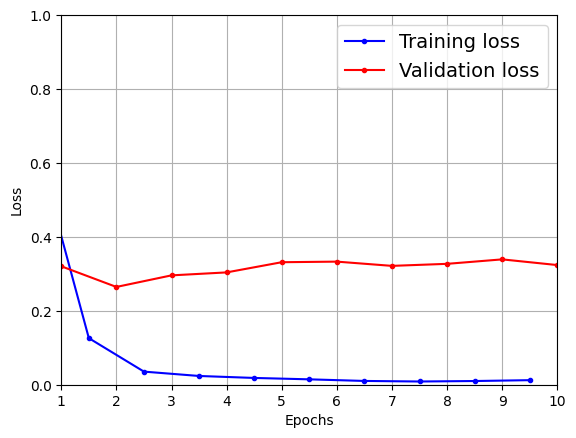

In [76]:
plot_learning_curves(phase2_history.history["loss"], phase2_history.history["val_loss"])

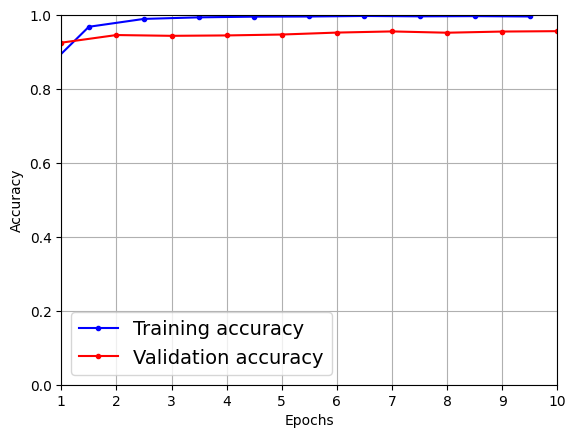

In [77]:
plot_accuracy_curves(phase2_history.history["accuracy"], phase2_history.history["val_accuracy"])

In [78]:
# confusion matrix
from sklearn.metrics import confusion_matrix

#Predict
y_prediction = final_model.predict(X_validation)

# converting the predictions into labels assuming one-hot
predicted_labels = np.argmax(y_prediction, axis=1)


#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_validation, predicted_labels)

print(class_names)
print(result)

90/90 [==============================] - 8s 32ms/step
['AcademicalVillage', 'AldermanLibrary', 'AlumniHall', 'AquaticFitnessCenter', 'BavaroHall', 'BrooksHall', 'ClarkHall', 'MadisonHall', 'MinorHall', 'NewCabellHall', 'NewcombHall', 'OldCabellHall', 'OlssonHall', 'RiceHall', 'Rotunda', 'ScottStadium', 'ThorntonHall', 'UniversityChapel']
[[ 70   1   0   0   0   0   0   0   0   1   0   0   0   0   6   0   1   0]
 [  0 144   0   0   0   0   0   0   0   0   0   0   1   0   0   2   0   1]
 [  0   0  80   0   0   0   0   0   0   0   0   0   0   0   0   2   0   0]
 [  0   0   0 112   0   0   0   0   0   0   0   0   0   1   0   1   4   0]
 [  0   0   0   0  23   0   1   0   0   0   2   0   0   0   0   0   1   0]
 [  0   0   0   0   0  78   0   0   0   0   0   0   0   0   2   0   0   0]
 [  0   0   0   2   0   0 162   0   1   1   0   0   0   1   1   1   2   0]
 [  0   0   0   0   1   0   0  62   0   0   0   0   0   0   1   1   1   0]
 [  0   1   0   0   0   0   0   0 143   0   0   0   0   0   

Overall looks like the pre-trained learning transfer model performed very well. It makes a few errors but generally is very strong.

It also has a validation accuracy of 0.95 while my custom model only hit 0.72, so this performs much better across the board.

Run classificaiton report to compare the two and be done.

In [50]:
import numpy as np
# stopped using A100 GPU to preserve credits, do not want to wait another 2 hours
# to train transfer learning model for this
confusion_matrix_pretrained = np.array([
 [ 70,   1,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   6,   0,   1,   0,],
 [  0, 144,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   2,   0,   1],
 [  0,   0,  80,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   2,   0,   0,],
 [  0,   0,   0, 112,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   1,   4,   0,],
 [  0,   0,   0,   0,  23,   0,   1,   0,   0,   0,   2,   0,   0,   0,   0,   0,   1,   0,],
 [  0,   0,   0,   0,   0,  78,   0,   0,   0,   0,   0,   0,   0,   0,   2,   0,   0,   0,],
 [  0,   0,   0,   2,   0,   0, 162,   0,   1,   1,   0,   0,   0,   1,   1,   1,   2,   0,],
 [  0,   0,   0,   0,   1,   0,   0,  62,   0,   0,   0,   0,   0,   0,   1,   1,   1,   0,],
 [  0,   1,   0,   0,   0,   0,   0,   0, 143,   0,   0,   0,   0,   0,   0,   0,   0,   0,],
 [  0,   0,   1,   2,   0,   0,   0,   0,   1, 121,   0,   2,   0,   0,   0,   0,   2,   1],
 [  0,   1,   0,   0,   0,   0,   0,   0,   2,   3, 132,   0,   0,   0,   1,   0,   2,   0,],
 [  1,   0,   0,   0,   0,   0,   3,   1,   2,   3,   0, 155,   0,   1,   1,   0,   0,   0,],
 [  0,   0,   0,   2,   0,   0,   0,   0,   4,   0,   0,   0, 204,   2,   0,   1,   2,   0,],
 [  0,   1,   0,   0,   0,   0,   1,   0,   0,   1,   0,   0,   0, 279,   0,   2,   0,   0,],
 [  3,   1,   0,   1,   0,   1,   1,   2,   0,   0,   0,   0,   0,   0, 295,   1,   1,   0,],
 [  4,   0,   0,   1,   0,   1,   0,   2,   1,   0,   0,   1,   2,   1,   0, 262,   2,   1],
 [  0,   0,   0,   1,   0,   1,   1,   0,   0,   0,   0,   0,   2,   1,   0,   1, 234,   0,],
 [  0,   0,   1,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0, 177]
])

def prec_recall_f1(confusion_matrix):
  for i in range (len(confusion_matrix)):
    # walk the diagonal
    true_pos = confusion_matrix[i][i]
    # everything in same row minus true positive
    false_neg = np.sum(confusion_matrix[i,:]) - true_pos
    false_pos = np.sum(confusion_matrix[:,i]) - true_pos
    # calc prec, recall, f1
    prec = true_pos / (true_pos+false_pos)
    recall = true_pos / (true_pos + false_neg)
    f1 = (2*(prec*recall)) / (prec+recall)
    # formatting
    space = ""
    if i < 10:
      space = " "

    print(str(i) + space + "      " +  str("{:.2f}".format(prec)) + "       " +  str("{:.2f}".format(recall)) + "      " + str("{:.2f}".format(f1)))

In [51]:
print("      Precision   Recall   F1-Score     ")
prec_recall_f1(confusion_matrix_pretrained)

      Precision   Recall   F1-Score     
0       0.90       0.89      0.89
1       0.97       0.97      0.97
2       0.98       0.98      0.98
3       0.93       0.95      0.94
4       0.96       0.85      0.90
5       0.95       0.97      0.96
6       0.96       0.95      0.95
7       0.93       0.94      0.93
8       0.93       0.99      0.96
9       0.93       0.93      0.93
10      0.99       0.94      0.96
11      0.98       0.93      0.95
12      0.98       0.95      0.96
13      0.98       0.98      0.98
14      0.96       0.96      0.96
15      0.96       0.94      0.95
16      0.93       0.97      0.95
17      0.98       0.98      0.98


This model greatly increases the scores of all of the classes. It especially increases the scores of the bad models namely 3,4, and 7 class ids up to a much higher F1 score. No class now has bad performance, however the worst class has an F1 score of 0.89. This class 0 corresponds to the Academical village.

# Step 5: Reflection

Write at least a paragraph answering these prompts: How did your own network perform in comparison to the pre-trained one? What are the major differences between the architectures? Additionally, report on your experience implementing different models for this assignment (Was it hard/easy/fun?, from which part did you learn the most?)!

My own network performed alright with a validation accuracy of 0.72, while my pre-trained model with transfer learning performed very well with a validation accuracy of 0.95.

One of the biggest noticeable differences between my custom architecture and the pre-trained was the number of layers. My custom implementation only had 13 layers, while efficientnetv2m had hundreds. Efficientnetv2m was also able to implement all of these layers while only using double the number of parameters that I did in my custom CNN. Lastly, efficientnetv2m also made use of some non trainable paramters while my custom CNN did not.

I learned a great deal about constructing a CNN, but I am still iffy on why each step occurs in a CNN such as convolution, pooling, dense layers etc. With the help of the slides I think I will get it fully though. I learned a lot about how to solve overfitting, difference between max-pooling and average pooling, powerful pre-trained keras models, and general patterns for pooling and convolution. Overall the assignment took me a long time and I ended up spending $10 on computing credits to get more memory and train these models much faster. Without it I do not think this assignment is do-able or you will learn anything from it; otherwise it is a great and very cool assignment.